<a href="https://colab.research.google.com/github/subedikushal/Aurshal/blob/main/Mistral_Finetune_on_IEEE_Disease_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Installation of necessary library

1. %%capture: This is a Jupyter notebook magic command. It's used to suppress the output of the cell. In simpler terms, it prevents the installation logs from cluttering your notebook.

2. %pip install -U ...: This line is using another Jupyter magic command (%pip) which allows you to run pip commands (Python's package manager) directly within the notebook. It is used to install or upgrade (using -U) the following packages:

- **transformers**: This library, developed by Hugging Face, provides pre-trained models for various NLP tasks and tools to fine-tune them.
- **datasets**: Also from Hugging Face, this library simplifies loading and processing datasets for NLP.
- **accelerate**: This library helps with training and inference on various hardware (like GPUs) with less code.
- **peft**: (Parameter-Efficient Fine-Tuning) This library allows efficient fine-tuning of large language models with techniques like LoRA, saving memory and compute.
- **trl**: (Transformer Reinforcement Learning) This library helps apply reinforcement learning techniques to transformer models.
- **bitsandbytes**: This library enables using 8-bit optimizers to reduce memory footprint during training.
- **wandb**: (Weights & Biases) This library helps track experiments, log metrics, and visualize results, useful for monitoring training progress.

In [ ]:
%%capture
%pip install -U transformers
%pip install -U datasets
%pip install -U accelerate
%pip install -U peft
%pip install -U trl
%pip install -U bitsandbytes
%pip install -U wandb
%pip install -U accelerator

### Importing Modules and Classes

In [ ]:
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import (
    LoraConfig,
    PeftModel,
    prepare_model_for_kbit_training,
    get_peft_model,
)
import os, torch
from datasets import load_dataset
from trl import SFTTrainer, setup_chat_format
import pandas as pd


### Observing the data

Here we observe the data using the pandas library.

- `index_col=False` instructs pandas to not use the first column of the CSV as the index (row labels) of the resulting DataFrame. Instead, pandas will create a default numeric index.

In [ ]:

# Load the dataset
data = pd.read_csv('disease_train.csv', index_col=False)

# Display the first few rows
print(data.head())

                            prognosis  \
0                    Aarskog syndrome   
1                       Aase syndrome   
2           Abdominal aortic aneurysm   
3     Abnormal uterine bleeding (AUB)   
4  Acetaminophen and codeine overdose   

                                            symptoms  
0  belly button that sticks out, bulge in the gro...  
1  wide-set eyes with droopy eyelids, absent or s...  
2  pain in the abdomen, fainting/drowsiness, clam...  
3  bleeding or spotting from the vagina between p...  
4  fainting/drowsiness, clammy skin, nausea and v...  


### Basic Pre-configuration Required

1. `device`: This is a variable that will store the device to be used for computation. It can be either a CPU or a GPU.
2. `torch_dtype`: This variable stores the data type that will be used for tensors (the fundamental data structures in PyTorch).
  - `torch.float16`: This specifies that the data type will be 16-bit floating point. This is also known as "half precision".
  
  Using torch.float16 can reduce memory usage and potentially speed up computations, especially on GPUs that support half-precision operations. However, it may also reduce the precision of the calculations.

3. `attn_implementation`: This variable stores the implementation mode for the attention mechanism in the model.
  - `"eager"`: This string indicates that the attention mechanism will be executed in "eager mode".
  In eager mode, operations are executed immediately as they are encountered. This is the default mode in PyTorch and is generally easier to debug and work with. Other attention implementations, like "flash attention," might offer performance benefits but could require specific hardware or software configurations.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch_dtype = torch.float16
attn_implementation = "eager"

### Model Selection

In [ ]:
base_model = "mistralai/Mistral-7B-Instruct-v0.3"

### Loading the model quantized with QLoRA Configuration

#### QLoRA Configuration
This part sets up the configuration for quantizing the model using a technique called QLoRA (Quantized Low-Rank Adaptation). Quantization is a method to reduce the memory footprint and computational cost of large language models by using lower precision number formats for the model's weights. QLoRA is a specific approach that combines quantization with Low-Rank Adaptation (LoRA), which makes fine-tuning more efficient.

- `bnb_config = BitsAndBytesConfig(...)`: This line creates a configuration object called bnb_config using the BitsAndBytesConfig class. This object will hold the settings for how the model should be quantized.

- `load_in_4bit=True`: This tells the config that we want to load the model's weights in 4-bit precision. This significantly reduces the memory required to store the model.

- `bnb_4bit_quant_type="nf4"`: This specifies the type of 4-bit quantization to use. "nf4" stands for Normalized Float 4, a specific quantization technique.

- `bnb_4bit_compute_dtype=torch_dtype`: This sets the data type to be used for computations during training and inference. torch_dtype was previously set to torch.float16, meaning computations will be done in 16-bit floating-point precision (also known as half precision).

- `bnb_4bit_use_double_quant=True`: This enables double quantization, which applies a second round of quantization to further reduce the model's size.



In [ ]:
# QLoRA config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch_dtype,
    bnb_4bit_use_double_quant=True,
)

# Load model
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    quantization_config=bnb_config,
    device_map=device,
    attn_implementation=attn_implementation
)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [ ]:
# LoRA config
peft_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=['up_proj', 'down_proj', 'gate_proj', 'k_proj', 'q_proj', 'v_proj', 'o_proj']
)
model = get_peft_model(model, peft_config)

In [ ]:
train_dataset = load_dataset("csv", data_files="./disease_train.csv", split='train')
test_dataset = load_dataset("csv", data_files="./disease_test.csv", split='train')
train_dataset
# dataset = dataset.shuffle(seed=65)

Dataset({
    features: ['prognosis', 'symptoms'],
    num_rows: 391
})

In [ ]:
def formatting_func(example):
    text = f"### Question: {example['symptoms']}\n ### Answer: {example['prognosis']}"
    return text

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))

In [ ]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = test_dataset.map(generate_and_tokenize_prompt)

805


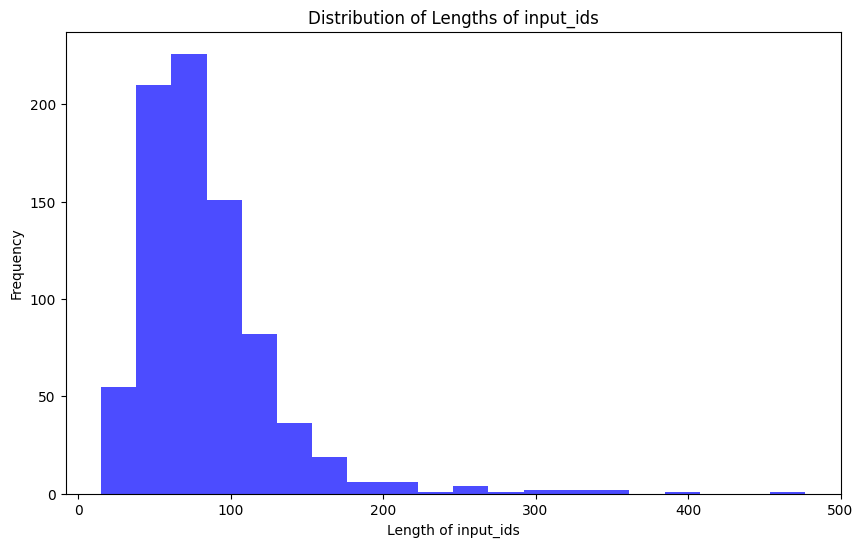

In [ ]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [ ]:
max_length = 512 # This was an appropriate max length for my dataset

def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [ ]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt2)
tokenized_val_dataset = test_dataset.map(generate_and_tokenize_prompt2)

Map:   0%|          | 0/414 [00:00<?, ? examples/s]

805


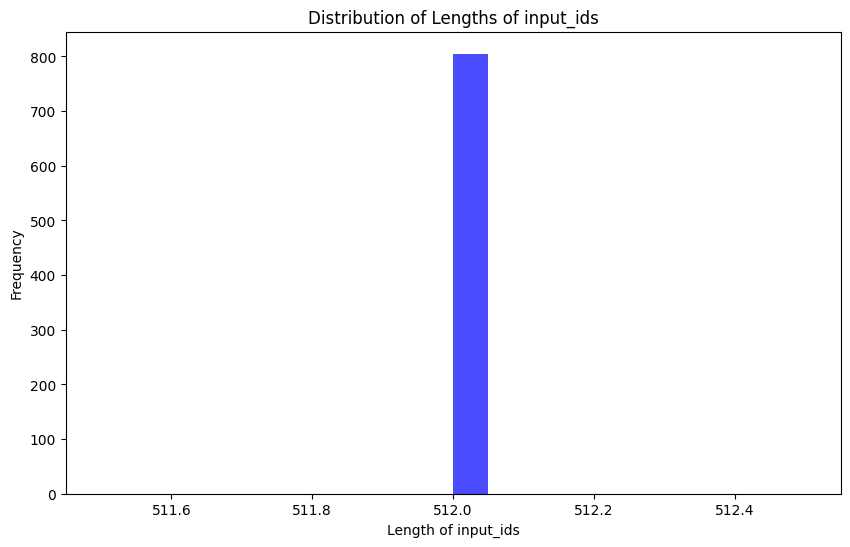

In [ ]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [ ]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): PeftModelForCausalLM(
      (base_model): LoraModel(
        (model): MistralForCausalLM(
          (model): MistralModel(
            (embed_tokens): Embedding(32768, 4096)
            (layers): ModuleList(
              (0-31): 32 x MistralDecoderLayer(
                (self_attn): MistralAttention(
                  (q_proj): lora.Linear4bit(
                    (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.05, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=4096, out_features=16, bias=False)
                    )
                    (lora_B): ModuleDict(
                      (default): Linear(in_features=16, out_features=4096, bias=False)
                    )
                    (lora_embedding_A): ParameterDict()
    

In [ ]:
print_trainable_parameters(model)

trainable params: 41943040 || all params: 3800305664 || trainable%: 1.1036754331979965


In [ ]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

In [ ]:
from accelerate import Accelerator
accelerator = Accelerator()

In [ ]:
model = accelerator.prepare_model(model)

In [ ]:
import transformers
from datetime import datetime

project = "ieee-disease-finetune"
base_model_name = "mistral"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=2,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        gradient_checkpointing=True,
        max_steps=500,
        learning_rate=2.5e-5, # Want a small lr for finetuning
        bf16=True,
        optim="paged_adamw_8bit",
        logging_steps=25,              # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=25,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=25,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        report_to="wandb",           # Comment this out if you don't want to use weights & baises
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss
25,2.233000,1.823876
50,1.563000,1.674898
75,1.501100,1.600665
100,1.437800,1.546187
125,1.429900,1.481493


**Restart kernel before inference.**

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-Instruct-v0.3"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Mistral, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True,
)

eval_tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True)

In [ ]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, "mistral-ieee-disease-finetune/checkpoint-300")

In [ ]:
eval_prompt = "Can you tell me the symptoms of cataract?"
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=100, repetition_penalty=1.15)[0], skip_special_tokens=True))